# Applying the Hidden Markov Model on Budget allocation

The hidden markov model would recommend a budget using conversion state transitions, budget emissions, and return on investment indicators 

### Objective
Minimize the budget _B<sub>t</sub>_ to transition from state _S<sub>t</sub>_ to _S<sub>t+1</sub>_

### Subject to
* Sum of _B<sub>t</sub>_ <= _B_;  for all _t_
* RMS of _R_ <= $\epsilon$; where _R_ is the Residual of the expected and actual return on investmenet _B_
* Sum of _S<sub>t+1</sub> - S<sub>t</sub>_ <= _T_; where _T_ is the total allowable time period to complete all transitions from S<sub>start</sub> to S<sub>final</sub>

#### Reference
[Analyzing Time Series Data with Markov Transition Matrices](https://medium.com/towards-data-science/time-series-data-markov-transition-matrices-7060771e362b)

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True


## Instantiate Classes

In [2]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
import tensorflow_probability as tfp
import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
from rezaware.modules.etl.loader import sparkFile as file
# from rezaware.modules.etl.loader import __propAttr__ as attr

''' restart initiate classes '''
if debug:
    import importlib
    # db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write BigQuery dataset for hypothese testing"
# clsSDB = db.dataWorkLoads(
#     desc=__desc__,
#     db_type = 'bigquery',
#     db_driver=None,
#     db_hostIP=None,
#     db_port = None,
#     db_name = None,
#     db_schema='combined_data_facebook_ads',
#     spark_partitions=None,
#     spark_format = 'bigquery',
#     spark_save_mode=None,
#     # spark_jar_dir = _jar,
# )
clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    store_mode='local-fs',
    store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

2025-02-17 16:32:11.020440: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 16:32:12.839450: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 16:32:14.006228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739781135.051761   76262 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739781135.263028   76262 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 16:32:17.077397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

All functional __PROPATTR__-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
All functional APP-libraries in REZAWARE-package of REZAWARE-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete

read and write BigQuery dataset for hypothese testing class initialization and load complete!


## Load data

In [3]:
options = {
    "inferSchema":True,
    "header":True,
    "delimiter":",",
    "pathGlobFilter":'*.csv',
    "recursiveFileLookup":True,
}

sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path="mining/data/budget/",  # optional - relative path, w.r.t. self.storeRoot
        file_name="complete-60-accounts.csv",  # optional - name of the file to read
        file_type=None,  # optional - read all the files of same type
        **options,
)
print("Loaded %d rows" % sdf.count())
# sdf.printSchema()

25/02/17 16:32:55 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/02/17 16:32:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/02/17 16:32:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/17 16:32:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
                                                                                

Loaded 61513 rows


## Currency convertion

In [2]:
# Corrected code
sdf = sdf.withColumn(
    "spend_usd",
    F.when(F.col('account_currency').isin('CAD'), F.col('spend') * 0.70)
     .when(F.col('account_currency').isin('EUR'), F.col('spend') * 1.05)
     .when(F.col('account_currency').isin('THB'), F.col('spend') * 0.03)
     .when(F.col('account_currency').isin('INR'), F.col('spend') * 0.012)
     .when(F.col('account_currency').isin('USD'), F.col('spend') * 1.00)
     .otherwise(F.col('spend') * 1.00)
)

sdf.printSchema()

NameError: name 'sdf' is not defined

## Filter data into Inputs and Outputs


In [1]:
_data_df= sdf.select('spend_usd','CPC', 'CPM', 'CTR', 'ROAS', 
                     'impressions', 'click', 'reach', 'frequency')\
            .where(F.col('goal').isin('OFFSITE_CONVERSIONS') & \
                  F.col('account_currency').isin('USD'))\
            .dropna().toPandas()
print(_data_df.shape)
''' keep 95 percentile of the data '''
for _col in _data_df.columns:
    _data_df = _data_df[_data_df[_col]<=\
                    _data_df[_col].mean()+2*_data_df[_col].std()]
# _data_df = _data_df.sample(n=1000)

print("data shape:", _data_df.shape)
print("some stats:\n", _data_df.describe())

NameError: name 'sdf' is not defined

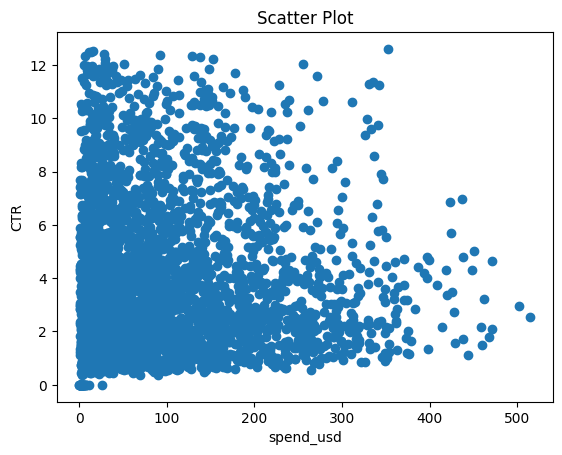

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

_x_col, _y_col = 'spend_usd', 'CTR'
plt.scatter(_data_df[_x_col],_data_df[_y_col])
plt.title("Scatter Plot")
plt.xlabel(_x_col)
plt.ylabel(_y_col)
plt.show()

## Define the model

* [Probabilistic Modeling with TensorFlow Probability](https://www.scaler.com/topics/tensorflow/tensorflow-probability/)
* [Tensorflow probability examples](https://github.com/tensorflow/probability/tree/main/tensorflow_probability/examples/jupyter_notebooks)

## Split the train & test data

In [7]:
# Compile and train the standard neural network
_pred_cols = ['CPC', 'CPM', 'CTR', 'ROAS', 
              'click', 'impressions', 'frequency', 'reach']
_label_col = ['spend_usd']
X = np.array(_data_df[_pred_cols])
y = np.array(_data_df[_label_col])             
print("X: ",X.shape,"y: ", y.shape)

X:  (3772, 8) y:  (3772, 1)


## Custom loss function

In [39]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, LSTM, Lambda, SimpleRNN

# Step 1: Generate or load your data
# Example: Create dummy data
num_samples = 10000  # Number of samples
num_timesteps = 1  # Number of time steps
num_features = 8  # Number of features per time step
num_classes = 1  # Number of output classes

# X has shape (num_samples, num_features)
# X = np.random.rand(num_samples, num_features)  # Example input data
# Reshape X to (num_samples, num_timesteps, num_features)
X_reshaped = np.tile(X[:, np.newaxis, :], (1, num_timesteps, 1))

# y has shape (num_samples,)
# y = np.random.randint(0, num_classes, size=num_samples)  # Example target data
# Reshape y to (num_samples, num_timesteps, 1)
y_reshaped = np.tile(y[:, np.newaxis, np.newaxis], (1, num_timesteps, 1))

# Split data into training and testing sets
split = int(0.8 * X_reshaped.shape[0])  # 80% training, 20% testing
x_train, x_test = X_reshaped[:split], X_reshaped[split:]
y_train, y_test = y_reshaped[:split], y_reshaped[split:]

# Step 2: Define the model
# Input layer expects (num_timesteps, num_features)
inputs = Input(shape=(num_timesteps, num_features))

# LSTM layer for sequential data
x = LSTM(64, return_sequences=True)(inputs)
x = SimpleRNN(128, return_sequences=True)(inputs)
# Dense layer
x = Dense(32, activation='relu')(x)

# Output a distribution (e.g., Normal distribution) and extract the mean
outputs = Lambda(
    lambda t: tfp.distributions.Normal(loc=t, scale=1).mean(),  # Extract the mean
    output_shape=(num_timesteps, 32)  # Specify the output shape
)(x)

# Create the model
model = Model(inputs, outputs)

# Step 3: Define a custom loss function
def custom_loss(y_true, y_pred):
    # Ensure y_true has the correct shape [batch_size, num_timesteps, 1]
    y_true = tf.reshape(y_true, [-1, num_timesteps, 1])  # Reshape to [batch_size, num_timesteps, 1]

    # Recreate the distribution
    dist = tfp.distributions.Normal(loc=y_pred, scale=1)
    # Compute the negative log probability
    return -dist.log_prob(y_true)

# Step 4: Compile the model
model.compile(optimizer='adam', loss=custom_loss, 
              metrics=['accuracy', 'mean_absolute_error'])

# Step 5: Train the model
model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0)

# Step 8: Summary of the model
model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 1, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 1, 128)         │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_17 (Lambda)              │ (None, 1, 32)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,994 (253.89 KB)

 Trainable params: 21,664 (84.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,330 (169.26 KB)

In [40]:
model.evaluate(x_test, y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 6.8324e-05 - loss: 1369.2926 - mean_absolute_error: 37.3888  


[1551.1549072265625, 0.0001241721911355853, 44.439476013183594]

In [33]:
# Step 6: Evaluate the model on the test set
# Generate predictions for the test set
y_pred = model.predict(x_test)

# Print the shapes of y_test and y_pred
print("y_test shape:", y_test.shape)  # Should be (num_test_samples, num_timesteps, 1)
print("y_pred shape:", y_pred.shape)  # Should be (num_test_samples, num_timesteps, 32)

# Step 7: Evaluate the predictions
# Compute the mean squared error (MSE) between y_test and y_pred
mse = tf.keras.losses.MeanSquaredError()
mse_value = mse(y_test, y_pred).numpy()
print("Mean Squared Error (MSE) on test set:", mse_value)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
y_test shape: (755, 1, 1, 1)
y_pred shape: (755, 1, 32)
Mean Squared Error (MSE) on test set: 766.09204


## DistibutionLambda wrapper function

In [16]:
## DEPRECATED unused
from tensorflow.keras.layers import Layer
class DistributionLambdaLayer(Layer):
    def __init__(self, **kwargs):
        super(DistributionLambdaLayer, self).__init__(**kwargs)
        self.dist_lambda = tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(loc=t, scale=1)
        )

    def call(self, inputs):
        # Get the distribution
        distribution = self.dist_lambda(inputs)
        # Return a tensor (e.g., the mean of the distribution)
        return distribution.mean()